# Library

In [19]:
import numpy as np 
import matplotlib.pyplot as plt 

from prml.utils.datasets import (
    RegressionDataGenerator,
    ClassificationDataGenerator2,
    ClassificationDataGenerator3
)
from prml.utils.util import softmax,binary_cross_entropy
from prml.utils.plot import plot_classifier

# Model

In [15]:
class RegressorNN():
    def __init__(self,learning_rate=1e-1,max_iter=10000,threshold=1e-6,batch_size=100,random_state=0):
        self.learning_rate = learning_rate 
        self.max_iter = max_iter
        self.threshold = threshold 
        self.batch_size = batch_size
        self.random_state = random_state 
        self.layers = []
        self.loss_layer = None
        
    def add(self,layer):
        layer.random_state = self.random_state 
        layer.learning_rate = self.learning_rate 
        self.layers.append(layer)
        
    def forward(self,X,y):
        flow = X
        for layer in self.layers:
            flow = layer.forward(flow)
        loss = self.loss_layer.forward(flow,y)
        return loss
        
    def backward(self):
        v = self.loss_layer.backward(1)
        for layer in  self.layers[::-1]:
            v = layer.backward(v)
            
    def fit(self,X,y,loss):
        self.loss_layer = loss
        N = X.shape[0]
        
        losses = []
        for _ in range(self.max_iter):
            res = self.forward(X,y)
            losses.append(res)
            if res < self.threshold:
                return 
            self.backward()
        return losses

    def predict(self,X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

In [17]:
class ClassifierNN(RegressorNN):
    def predict(self,X):
        feature = super(ClassifierNN,self).predict(X)
        prob = softmax(feature)
        onehot = np.zeros_like(prob) 
        clas = prob.argmax(axis = 1)
        for k in range(onehot.shape[1]):
            onehot[clas == k,k] = 1
        return onehot 

# Layer 

In [3]:
class Dense():
    def __init__(self,output_size):
        self.initialize = False 
        self.learning_rate = None 
        self.random_state = None 
        self.output_size = output_size
        self.X = None
        self.W = None 
        self.b = None
        
    def forward(self,X):
        self.X = X
        if not self.initialize:
            np.random.seed(self.random_state)
            self.W = np.random.randn(X.shape[1],self.output_size)
            self.b = np.random.randn(self.output_size)
            self.initialize = True 
        return np.dot(X,self.W) + self.b 
    
    def backward(self,loss):
        dX = np.dot(loss,self.W.T)
        dW = np.dot(self.X.T,loss)
        db = loss.sum(axis = 0)
        self.W -= self.learning_rate*dW
        self.b -= self.learning_rate*db
        return dX

In [9]:
class Relu():
    def __init__(self):
        self.X = None 

    def forward(self,X):
        self.X = X
        return np.where(X > 0,X,0)
    
    def backward(self,loss):
        dX = np.zeros_like(self.X)
        dX[self.X >= 0] = 1
        return loss*dX

In [8]:
class MeanSquaredError():
    def __init__(self):
        self.predict = None 
        self.target = None
    def forward(self,predict,target):
        self.predict = predict
        self.target = target  
        return np.mean((predict - target)**2)/2
    def backward(self,loss):
        shape = self.target.shape[0]
        dX = loss*(self.predict - self.target)/shape
        return dX

In [7]:
class SigmoidCrossEntropy(): 
    def __init__(self): 
        self.predict = None 
        self.target = None 
    
    def forward(self,X,target): 
        self.predict = softmax(X) 
        self.target = target 
        return binary_cross_entropy(target,self.predict) 
    
    def backward(self,loss): 
        shape = self.target.shape[0] 
        return loss*(self.predict - self.target)/shape 

# Regression

In [10]:
def f(x):
    return x**3 - 9*x

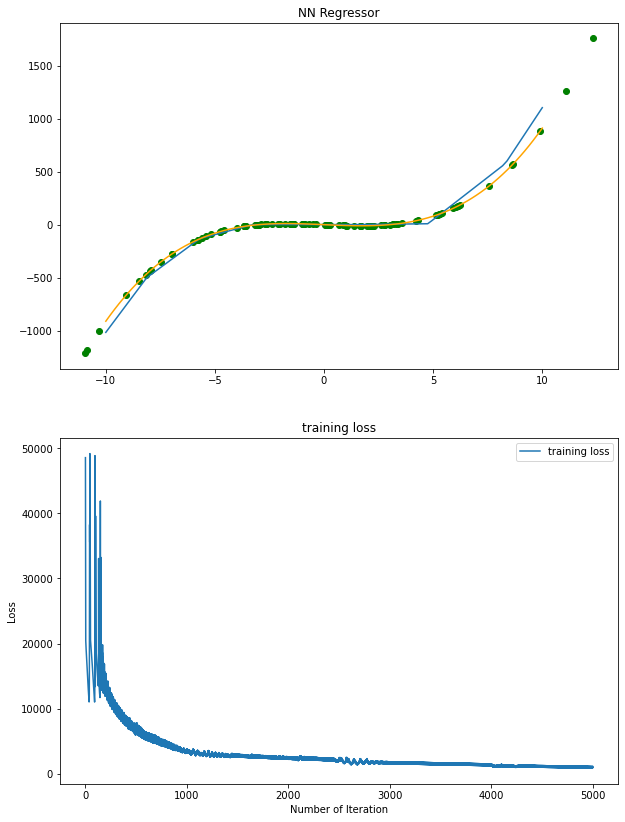

In [13]:
generator = RegressionDataGenerator(f)
X_tr,y_tr = generator(n = 100,std = 0.3,lower = -5,upper = 5) 

# training
model = Model(
    learning_rate = 1e-3, 
    max_iter = 5000
)
model.add(Dense(200))
model.add(Relu())
model.add(Dense(1))
losses = model.fit(X_tr,y_tr,loss = MeanSquaredError()) 

# plot prediction
X = np.linspace(-10,10,100).reshape(-1,1)
y_pred = model.predict(X) 
y_true = f(X)

cmaps = [[0.122, 0.467, 0.706],"orange","green"]
fig,ax = plt.subplots(2,1,figsize = (10,14))
ax[0].plot(X,y_pred,label="Predict",color=cmaps[0])
ax[0].plot(X,y_true,label="Ground Truth",color=cmaps[1])
ax[0].scatter(X_tr,y_tr,label="Training Data",color=cmaps[2])
ax[0].set_title("NN Regressor")

# plot loss 
ax[1].plot(losses,label = "training loss")
ax[1].set_xlabel("Number of Iteration")
ax[1].set_ylabel("Loss")
ax[1].set_title("training loss")

plt.legend()
plt.show()

# Classification

In [14]:
def g(x):
    return x**3/20 - x

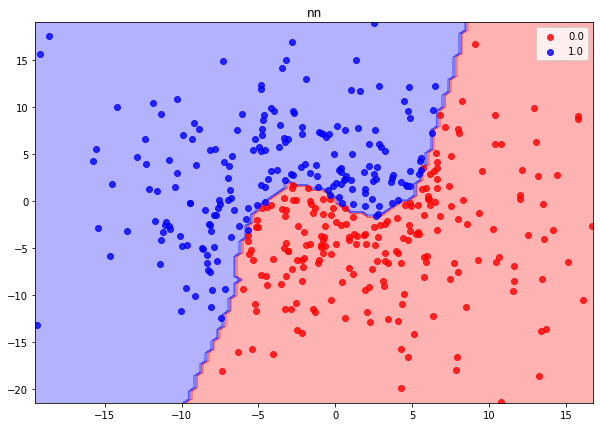

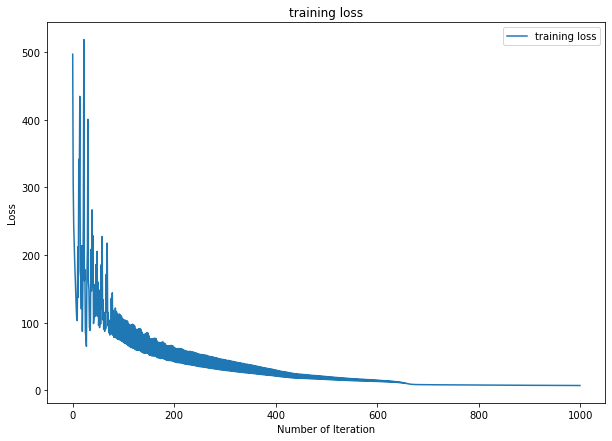

In [20]:
gen = ClassificationDataGenerator2(g) 
X,y = gen(n = 400,
          encoding="onehot",
          x_lower = -7,
          x_upper = 7,
          y_lower = -7,
          y_upper = 7)  

# plot prediction 
model = ClassifierNN(max_iter=1000) 
model.add(Dense(30))
model.add(Relu())
model.add(Dense(2)) # two class classification
losses = model.fit(X,y,loss = SigmoidCrossEntropy())

# plot classifier 
plot_classifier(X,y,model,title="nn")

# plot loss
fig,ax = plt.subplots(1,1,figsize = (10,7))
ax.plot(losses,label = "training loss")
ax.set_xlabel("Number of Iteration")
ax.set_ylabel("Loss")
ax.set_title("training loss")
plt.legend()
plt.show()